## Import Necessary Libraries

In [1]:
import os
import re
import nltk
import random
import gensim
import requests
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
from gensim import corpora
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from multiprocessing import Pool
from nltk.corpus import stopwords
from gensim import corpora, models
from itertools import combinations
from collections import defaultdict
from nltk.tokenize import word_tokenize
from gensim.models.ldamodel import LdaModel
from nltk.corpus import PlaintextCorpusReader
from nltk.sentiment import SentimentIntensityAnalyzer

## Loading data

In [2]:
file_path = 'Tweets_with_location.csv'

# Read the file
try:
    tweets_df = pd.read_csv(file_path, encoding='ISO-8859-1')
except Exception as e:
    error = str(e)

# Check if the file was successfully read or report the error
if 'tweets_df' in locals():
    success = True
    preview = tweets_df.head()
else:
    success = False
    preview = error

#success, preview

# Display the first few rows of the dataframe
tweets_df.head()

,Name,UserName,Time,Text,Likes,Retweets,TweetURL,UserURL,City,Country,Unnamed: 10,Unnamed: 11
0,Gerald Butts,gmbutts,1/24/2022 22:24,I'm glad serious researchers are taking up thi...,17.0,50.0,https://twitter.com/gmbutts/status/14857402380...,https://twitter.com/gmbutts,0,0,NaN,NaN
1,Gerald Butts,gmbutts,1/24/2022 22:27,1. Partisan adhesion in Canada is weak and par...,2.0,31.0,https://twitter.com/gmbutts/status/14857409939...,https://twitter.com/gmbutts,0,0,NaN,NaN
2,Abigail Boyd,AbigailBoydMLC,3/7/2022 23:46,"Minister Ayers, what are you doing to assist t...",8.0,12.0,https://twitter.com/AbigailBoydMLC/status/1500...,https://twitter.com/AbigailBoydMLC,0,0,NaN,NaN
3,Warren Gunnels,GunnelsWarren,2/22/2022 23:49,I want cable news to cover the child poverty r...,5418.0,203000.0,https://twitter.com/GunnelsWarren/status/14962...,https://twitter.com/GunnelsWarren,0,0,NaN,NaN
4,Scalawag,scalawagmag,3/21/2022 21:45,"""If we don't adapt the internet to the reality...",1.0,9.0,https://twitter.com/scalawagmag/status/1506024...,https://twitter.com/scalawagmag,0,0,NaN,NaN


## Data cleaning

In [3]:
def remove_irrelevant_columns(df, columns_to_remove):
    """Remove irrelevant columns from the dataframe."""
    df = df.drop(columns=columns_to_remove, errors='ignore')
    return df

def handle_missing_values(df, columns):
    """Handle missing or placeholder values in specified columns."""
    for column in columns:
        # '0' is a placeholder for missing data
        df[column] = df[column].replace('0', None)
    return df

def convert_to_datetime(df, column):
    """Convert a column to datetime format."""
    df[column] = pd.to_datetime(df[column], errors='coerce')
    return df

def clean_text_data(df, text_column):
    """Clean the text data in a specified column."""
    def clean_text(text):
        if not isinstance(text, str):
            return text  # Return the original value if it's not a string
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove special characters and numbers
        text = re.sub(r'[^A-Za-z ]+', '', text)
        return text.strip()

    df[text_column] = df[text_column].apply(clean_text)
    return df

# Applying the functions to the dataset
tweets_cleaned = tweets_df.copy()
tweets_cleaned = remove_irrelevant_columns(tweets_cleaned, ['Unnamed: 10', 'Unnamed: 11'])
tweets_cleaned = handle_missing_values(tweets_cleaned, ['City', 'Country'])
tweets_cleaned = convert_to_datetime(tweets_cleaned, 'Time')
tweets_cleaned = clean_text_data(tweets_cleaned, 'Text')

# Displaying the first few rows of the cleaned dataframe
tweets_cleaned.head()

,Name,UserName,Time,Text,Likes,Retweets,TweetURL,UserURL,City,Country
0,Gerald Butts,gmbutts,2022-01-24 22:24:00,Im glad serious researchers are taking up this...,17.0,50.0,https://twitter.com/gmbutts/status/14857402380...,https://twitter.com/gmbutts,None,None
1,Gerald Butts,gmbutts,2022-01-24 22:27:00,Partisan adhesion in Canada is weak and partly...,2.0,31.0,https://twitter.com/gmbutts/status/14857409939...,https://twitter.com/gmbutts,None,None
2,Abigail Boyd,AbigailBoydMLC,2022-03-07 23:46:00,Minister Ayers what are you doing to assist th...,8.0,12.0,https://twitter.com/AbigailBoydMLC/status/1500...,https://twitter.com/AbigailBoydMLC,None,None
3,Warren Gunnels,GunnelsWarren,2022-02-22 23:49:00,I want cable news to cover the child poverty r...,5418.0,203000.0,https://twitter.com/GunnelsWarren/status/14962...,https://twitter.com/GunnelsWarren,None,None
4,Scalawag,scalawagmag,2022-03-21 21:45:00,If we dont adapt the internet to the reality o...,1.0,9.0,https://twitter.com/scalawagmag/status/1506024...,https://twitter.com/scalawagmag,None,None


## Basic Analysis

In [4]:
# Basic Statistics
num_tweets = tweets_cleaned.shape[0]
num_unique_users = tweets_cleaned['UserName'].nunique()
most_active_users = tweets_cleaned['UserName'].value_counts().head(5)
most_liked_tweet = tweets_cleaned.loc[tweets_cleaned['Likes'].idxmax()]
most_retweeted_tweet = tweets_cleaned.loc[tweets_cleaned['Retweets'].idxmax()]

basic_statistics = {
    "Number of Tweets": num_tweets,
    "Number of Unique Users": num_unique_users,
    "Most Active Users": most_active_users,
    "Most Liked Tweet": most_liked_tweet[['UserName', 'Text', 'Likes']],
    "Most Retweeted Tweet": most_retweeted_tweet[['UserName', 'Text', 'Retweets']]
}

basic_statistics

{'Number of Tweets': 10814,
 'Number of Unique Users': 8169,
 'Most Active Users': PCarterClimate    65
 insideclimate     36
 bobhillbrain      34
 ECOWARRIORSS      34
 climatecouncil    31
 Name: UserName, dtype: int64,
 'Most Liked Tweet': UserName                                           WhipRealer
 Text        Its a farce Always has been Always will be Cli...
 Likes                                                213000.0
 Name: 9414, dtype: object,
 'Most Retweeted Tweet': UserName                                                POTUS
 Text        Congratulations to EmmanuelMacron on his reele...
 Retweets                                            1505000.0
 Name: 5580, dtype: object}

## Temporal analysis

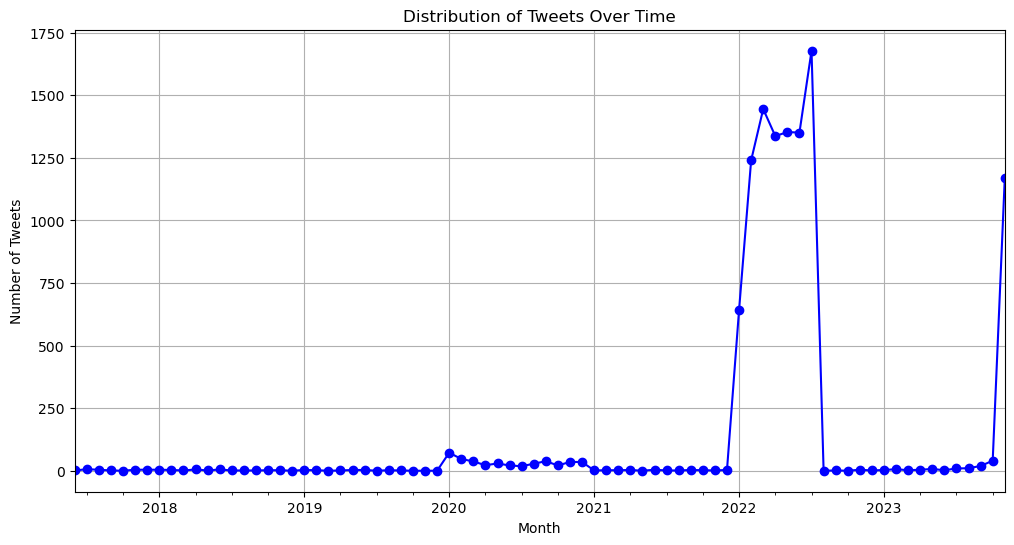

In [5]:
# Temporal Analysis: Distribution of tweets over time
tweets_cleaned.set_index('Time', inplace=True)

# Resampling to get tweet counts per month
monthly_tweets = tweets_cleaned.resample('M').size()

# Plotting
plt.figure(figsize=(12, 6))
monthly_tweets.plot(kind='line', color='blue', marker='o')
plt.title('Distribution of Tweets Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()

## User engagement analysis

In [6]:
# Top Engaged Users based on Likes and Retweets
top_users_likes = tweets_cleaned.groupby('UserName')['Likes'].sum().sort_values(ascending=False).head(5)
top_users_retweets = tweets_cleaned.groupby('UserName')['Retweets'].sum().sort_values(ascending=False).head(5)

# Displaying the top engaged users based on likes and retweets
top_engaged_users = {
    "Top Users by Likes": top_users_likes,
    "Top Users by Retweets": top_users_retweets
}

top_engaged_users

{'Top Users by Likes': UserName
 WhipRealer         213000.0
 lifesupremacist    192000.0
 POTUS              189356.0
 NeeNeinNyetNo      174890.0
 AOC                149000.0
 Name: Likes, dtype: float64,
 'Top Users by Retweets': UserName
 POTUS              1512787.0
 lifesupremacist    1166000.0
 AOC                 754000.0
 mchooyah            409000.0
 RBReich             405552.0
 Name: Retweets, dtype: float64}

In [7]:
# Extracting a few of the most liked and retweeted tweets for content analysis
most_liked_tweets_content = tweets_cleaned.loc[tweets_cleaned['Likes'].nlargest(5).index]
most_retweeted_tweets_content = tweets_cleaned.loc[tweets_cleaned['Retweets'].nlargest(5).index]

# Displaying the content of these tweets
most_engaged_tweets_content = {
    "Most Liked Tweets Content": most_liked_tweets_content[['UserName', 'Text', 'Likes']],
    "Most Retweeted Tweets Content": most_retweeted_tweets_content[['UserName', 'Text', 'Retweets']]
}

most_engaged_tweets_content

{'Most Liked Tweets Content':                             UserName  \
 Time                                   
 2022-07-16 14:36:00       WhipRealer   
 2022-07-18 16:10:00  lifesupremacist   
 2022-04-24 22:50:00            POTUS   
 2022-04-23 22:35:00  RyanWil62993886   
 2022-04-23 22:35:00      johnastoehr   
 2022-04-23 22:35:00    NeeNeinNyetNo   
 2022-06-24 21:07:00              AOC   
 
                                                                   Text  \
 Time                                                                     
 2022-07-16 14:36:00  Its a farce Always has been Always will be Cli...   
 2022-07-18 16:10:00  A gathering of white people on colonized land ...   
 2022-04-24 22:50:00  Congratulations to EmmanuelMacron on his reele...   
 2022-04-23 22:35:00  Labor Lap Dog Gilbert allowing Wong to spew li...   
 2022-04-23 22:35:00  This is kind of care we need for climate chang...   
 2022-04-23 22:35:00  Crazy how a guy self immolates in the countrys...   


## Topic Analysis

In [8]:
# Preprocess the Text:

nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    if not isinstance(text, str):
        return []
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    return [word for word in words if word not in stop_words and word.isalpha()]

tweets_cleaned['Processed_Text'] = tweets_cleaned['Text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /Users/zahra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zahra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# Perform LDA Topic Modeling

def perform_lda(text_data, num_topics=5):
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    topics = lda_model.print_topics(num_words=4)
    return lda_model, topics  # Return both the model and the topics

In [10]:
# Applying LDA topic modeling
tweets_preprocessed = tweets_cleaned['Processed_Text']
lda_model, topics = perform_lda(tweets_preprocessed)  # Capture both outputs

# Print summarized topics
print("Summarized Topics:")
for topic in topics:
    print(topic)

# Print detailed topics
num_topics = 5  # number of topics
words_per_topic = 10  # number of words to display per topic

print("\nDetailed Topics:")
for i in range(num_topics):
    words = lda_model.show_topic(i, topn=words_per_topic)
    topic_words = ", ".join([word for word, prob in words])
    print(f"Topic {i}: {topic_words}")

Summarized Topics:
(0, '0.055*"climate" + 0.046*"change" + 0.012*"replying" + 0.006*"people"')
(1, '0.025*"climatechange" + 0.017*"help" + 0.014*"emirates" + 0.013*"fund"')
(2, '0.041*"climate" + 0.032*"change" + 0.009*"global" + 0.006*"climatechange"')
(3, '0.009*"energy" + 0.008*"climate" + 0.007*"climatechange" + 0.006*"change"')
(4, '0.041*"climate" + 0.033*"change" + 0.009*"climatechange" + 0.005*"us"')

Detailed Topics:
Topic 0: climate, change, replying, people, us, action, dont, like, would, need
Topic 1: climatechange, help, emirates, fund, fair, share, lossanddamage, climate, hit, paying
Topic 2: climate, change, global, climatechange, warming, emissions, new, heat, carbon, c
Topic 3: energy, climate, climatechange, change, gas, eu, sustainable, solar, oil, green
Topic 4: climate, change, climatechange, us, new, health, water, global, people, food


In [11]:
# 'tweets_preprocessed' contains the preprocessed text data
dictionary = corpora.Dictionary(tweets_preprocessed)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tweets_preprocessed]

lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics=5, id2word=dictionary, passes=15)


# Function to assign the most probable topic to each tweet
def assign_topics(lda_model, corpus):
    topic_numbers = []
    for doc in corpus:
        topics = lda_model.get_document_topics(doc)
        topic_numbers.append(sorted(topics, key=lambda x: x[1], reverse=True)[0][0])
    return topic_numbers

tweets_cleaned['Topic'] = assign_topics(lda_model, doc_term_matrix)

# Assign a topic number to each tweet
tweets_cleaned['Topic'] = assign_topics(lda_model, doc_term_matrix)

# Now apply the mapping
topic_names = {
    0: "Global Climate Challenges",
    1: "Climate Change Discourse",
    2: "Environmental Emissions and Energy",
    3: "Climate Justice and Responsibility",
    4: "Climate Debate and Controversy"
}

tweets_cleaned['Topic_Name'] = tweets_cleaned['Topic'].map(topic_names)

# Display the first few rows to verify the topic names are added
print(tweets_cleaned[['Text', 'Topic', 'Topic_Name']].head())

                                                                  Text  Topic  \
Time                                                                            
2022-01-24 22:24:00  Im glad serious researchers are taking up this...      1   
2022-01-24 22:27:00  Partisan adhesion in Canada is weak and partly...      1   
2022-03-07 23:46:00  Minister Ayers what are you doing to assist th...      1   
2022-02-22 23:49:00  I want cable news to cover the child poverty r...      1   
2022-03-21 21:45:00  If we dont adapt the internet to the reality o...      1   

                                   Topic_Name  
Time                                           
2022-01-24 22:24:00  Climate Change Discourse  
2022-01-24 22:27:00  Climate Change Discourse  
2022-03-07 23:46:00  Climate Change Discourse  
2022-02-22 23:49:00  Climate Change Discourse  
2022-03-21 21:45:00  Climate Change Discourse  


## Sentiment Analysis

In [12]:
# Define the Sentiment Analysis Function
def analyze_sentiment(text):
    """Analyze the sentiment of the given text."""
    if not isinstance(text, str):
        return {"neg": 0, "neu": 0, "pos": 0, "compound": 0}  # Return neutral sentiment for non-string inputs
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

# Apply the Function to the Tweets
tweets_cleaned['Sentiment'] = tweets_cleaned['Text'].apply(analyze_sentiment)

# Display the Results
tweets_cleaned[['Text', 'Sentiment']].head()

,Text,Sentiment
Time,,
2022-01-24 22:24:00,Im glad serious researchers are taking up this...,"{'neg': 0.039, 'neu': 0.7, 'pos': 0.261, 'comp..."
2022-01-24 22:27:00,Partisan adhesion in Canada is weak and partly...,"{'neg': 0.148, 'neu': 0.759, 'pos': 0.094, 'co..."
2022-03-07 23:46:00,Minister Ayers what are you doing to assist th...,"{'neg': 0.055, 'neu': 0.824, 'pos': 0.122, 'co..."
2022-02-22 23:49:00,I want cable news to cover the child poverty r...,"{'neg': 0.179, 'neu': 0.728, 'pos': 0.093, 'co..."
2022-03-21 21:45:00,If we dont adapt the internet to the reality o...,"{'neg': 0.051, 'neu': 0.87, 'pos': 0.078, 'com..."


In [13]:
# Extract the compound sentiment score
tweets_cleaned['Compound_Score'] = tweets_cleaned['Sentiment'].apply(lambda x: x['compound'])

In [14]:
# Ensure 'Time' is set as the index and in datetime format
tweets_cleaned.index = pd.to_datetime(tweets_cleaned.index)

# Resample and calculate the average compound score monthly
monthly_sentiment = tweets_cleaned['Compound_Score'].resample('M').mean()

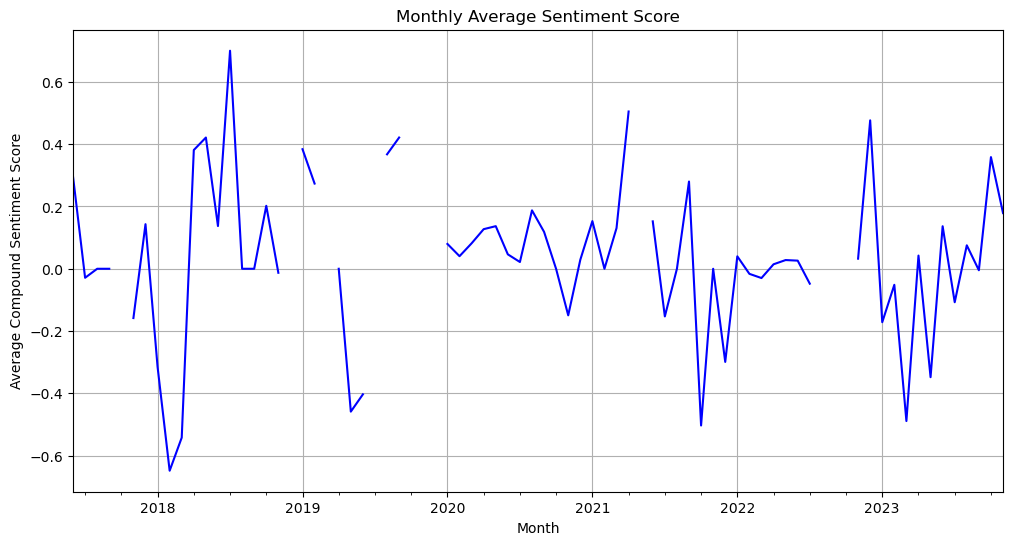

In [15]:
# Plotting the monthly average sentiment score
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(kind='line', color='blue')
plt.title('Monthly Average Sentiment Score')
plt.xlabel('Month')
plt.ylabel('Average Compound Sentiment Score')
plt.grid(True)
plt.show()

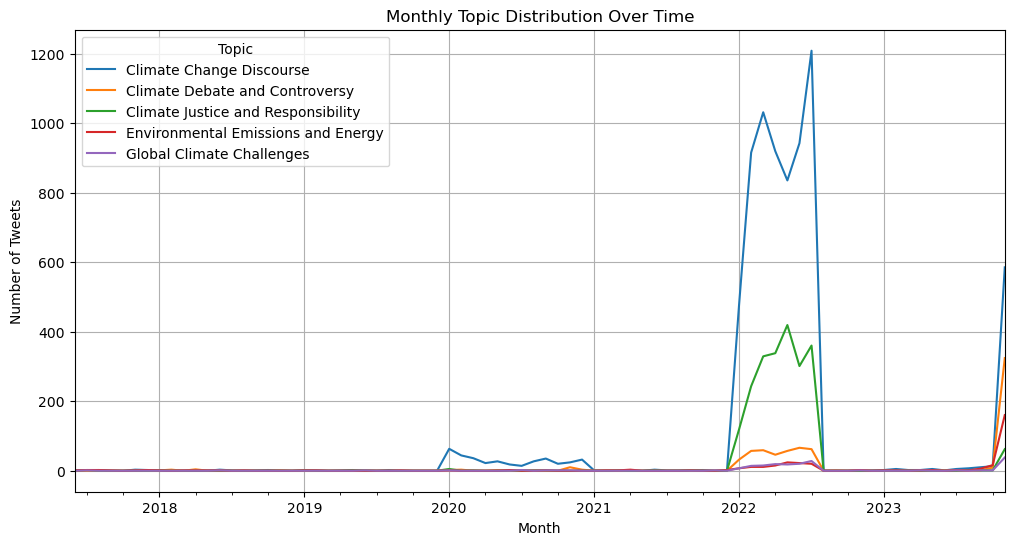

In [16]:
# Function to get dominant topic number and name
def get_dominant_topic_and_name(doc_bow):
    topic_distribution = lda_model.get_document_topics(doc_bow)
    topic_distribution = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
    topic_number = topic_distribution[0][0] if topic_distribution else None
    return topic_number, topic_names.get(topic_number, "Unknown")

# Assigning dominant topic number and name to each tweet
tweets_cleaned['Topic'], tweets_cleaned['Topic_Name'] = zip(*[get_dominant_topic_and_name(doc_bow) for doc_bow in doc_term_matrix])

# Ensure 'Time' is in datetime format and set as index
tweets_cleaned.index = pd.to_datetime(tweets_cleaned.index)

# Counting the number of tweets in each topic per month
monthly_topic_distribution = tweets_cleaned.groupby('Topic_Name').resample('M').size().unstack(fill_value=0)

# Plotting the topic distribution over time
monthly_topic_distribution.T.plot(kind='line', figsize=(12, 6))  # Transpose for proper formatting
plt.title('Monthly Topic Distribution Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.legend(title='Topic')
plt.grid(True)
plt.show()

## Geographical Analysis 

In [17]:
# Checking the contents of the 'City' and 'Country' columns
city_data_preview = tweets_cleaned['City'].value_counts().head()
country_data_preview = tweets_cleaned['Country'].value_counts().head()

# Standardizing country names
tweets_cleaned['Country'] = tweets_cleaned['Country'].replace({'CA': 'Canada', 'NY': 'United States'})

# Handling missing values (if any)
tweets_cleaned['City'].fillna('Unknown', inplace=True)
tweets_cleaned['Country'].fillna('Unknown', inplace=True)

# Aggregating Tweets by Location
city_counts = tweets_cleaned['City'].value_counts()
country_counts = tweets_cleaned['Country'].value_counts()

city_data_preview, country_data_preview, city_counts.head(), country_counts.head()

(New York      290
 Washington    198
 London        180
 Sydney        160
 Melbourne     143
 Name: City, dtype: int64,
 Australia         926
 United Kingdom    639
 Canada            533
 CA                377
 NY                367
 Name: Country, dtype: int64,
 Unknown       7044
 New York       290
 Washington     198
 London         180
 Sydney         160
 Name: City, dtype: int64,
 Unknown           5423
 Australia          926
 Canada             910
 United Kingdom     639
 United States      367
 Name: Country, dtype: int64)

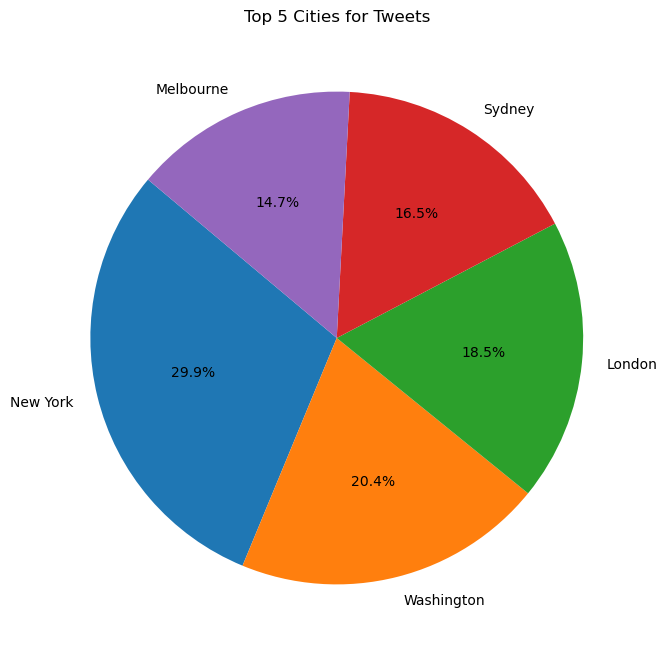

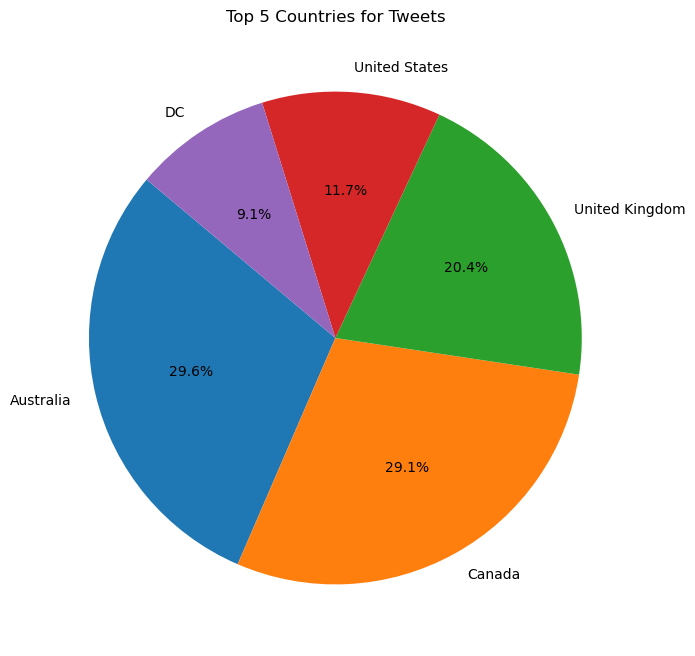

In [18]:
# Check and drop '0' from city_counts if it exists
if '0' in city_counts.index:
    city_counts = city_counts.drop('0')

# Check and drop 'Unknown' from city_counts if it exists
if 'Unknown' in city_counts.index:
    city_counts = city_counts.drop('Unknown')

# Now directly select the top 5 cities
top_cities = city_counts.head(5)

# Similarly, check and drop 'Unknown' from country_counts if it exists
if 'Unknown' in country_counts.index:
    country_counts = country_counts.drop('Unknown')

# Now directly select the top 5 countries
top_countries = country_counts.head(5)

# Proceed with plotting for top cities and countries
plt.figure(figsize=(8, 8))
top_cities.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Cities for Tweets')
plt.ylabel('')  # Hide the y-label

plt.figure(figsize=(8, 8))
top_countries.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Countries for Tweets')
plt.ylabel('')  # Hide the y-label

plt.show()

In [19]:
# ???????should we include unknown???????

In [20]:
# Inspect Location Data, Checking the contents of the 'City' and 'Country' columns

city_data_preview = tweets_cleaned['City'].value_counts().head()
country_data_preview = tweets_cleaned['Country'].value_counts().head()

city_data_preview, country_data_preview

(Unknown       7044
 New York       290
 Washington     198
 London         180
 Sydney         160
 Name: City, dtype: int64,
 Unknown           5423
 Australia          926
 Canada             910
 United Kingdom     639
 United States      367
 Name: Country, dtype: int64)

In [21]:
# Standardizing country names
tweets_cleaned['Country'] = tweets_cleaned['Country'].replace({'CA': 'Canada', 'NY': 'United States'})

# Handling missing values
tweets_cleaned['City'].fillna('Unknown', inplace=True)
tweets_cleaned['Country'].fillna('Unknown', inplace=True)

In [22]:
# Aggregating Tweets by Location

city_counts = tweets_cleaned['City'].value_counts()
country_counts = tweets_cleaned['Country'].value_counts()

print("Top Cities for Climate Change Tweets:")
print(city_counts.head())  # Display top 5 cities

print("\nTop Countries for Climate Change Tweets:")
print(country_counts.head())  # Display top 5 countries

Top Cities for Climate Change Tweets:
Unknown       7044
New York       290
Washington     198
London         180
Sydney         160
Name: City, dtype: int64

Top Countries for Climate Change Tweets:
Unknown           5423
Australia          926
Canada             910
United Kingdom     639
United States      367
Name: Country, dtype: int64


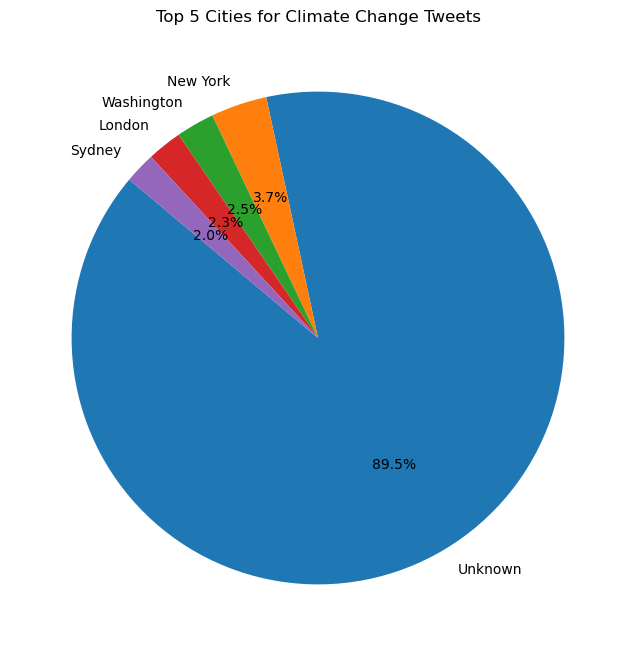

In [23]:
# Visualization
# Selecting the top 5 cities
top_cities = tweets_cleaned['City'].value_counts().head(5)

# Plotting
top_cities.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), startangle=140)
plt.title('Top 5 Cities for Climate Change Tweets')
plt.ylabel('')  # Hide the y-label
plt.show()

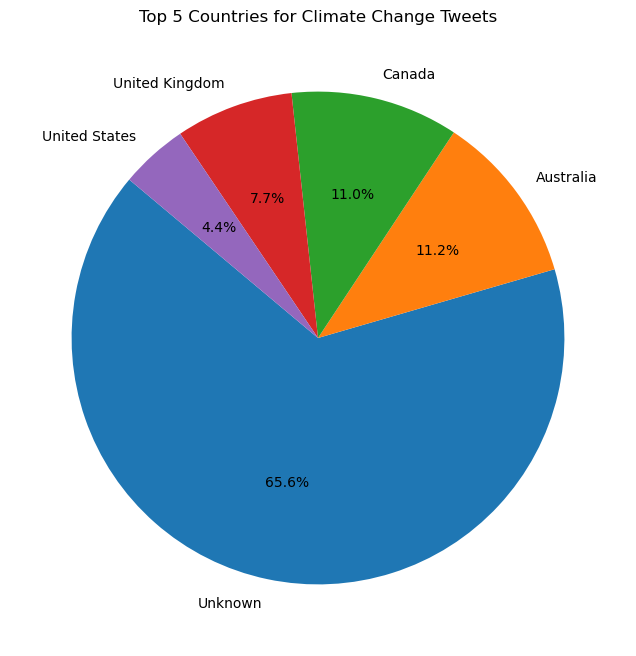

In [24]:
# Selecting the top 5 countries
top_countries = tweets_cleaned['Country'].value_counts().head(5)

# Plotting
top_countries.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), startangle=140)
plt.title('Top 5 Countries for Climate Change Tweets')
plt.ylabel('')  # Hide the y-label
plt.show()

## Word-clouds

In [25]:
# Download NLTK stop words
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

# Define additional removable words
list_removable = ['==', '===', '–', '"', '.']

def clean_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return []

    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove punctuation and convert to lower case
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Remove stopwords and additional removable characters
    tokens = [word for word in tokens if word not in stop_words and word not in list_removable]
    return tokens

# Apply the cleaning function to the 'Text' column
tweets_df['cleaned_text'] = tweets_df['Text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /Users/zahra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# Tokenize and clean text for each city
for city in set(tweets_df.City):
    # Join all tweets text for each city and tokenize
    city_text = ' '.join(tweets_df[tweets_df.City == city]['Text'].dropna())
    tokens = nltk.word_tokenize(city_text)
    # Remove punctuation, convert to lower case, and filter out stopwords
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words and word not in list_removable]

    # Creating a frequency distribution
    fdist = nltk.FreqDist(tokens)

In [27]:
# Calculate Frequency Distribution
fdist = nltk.FreqDist(tokens)

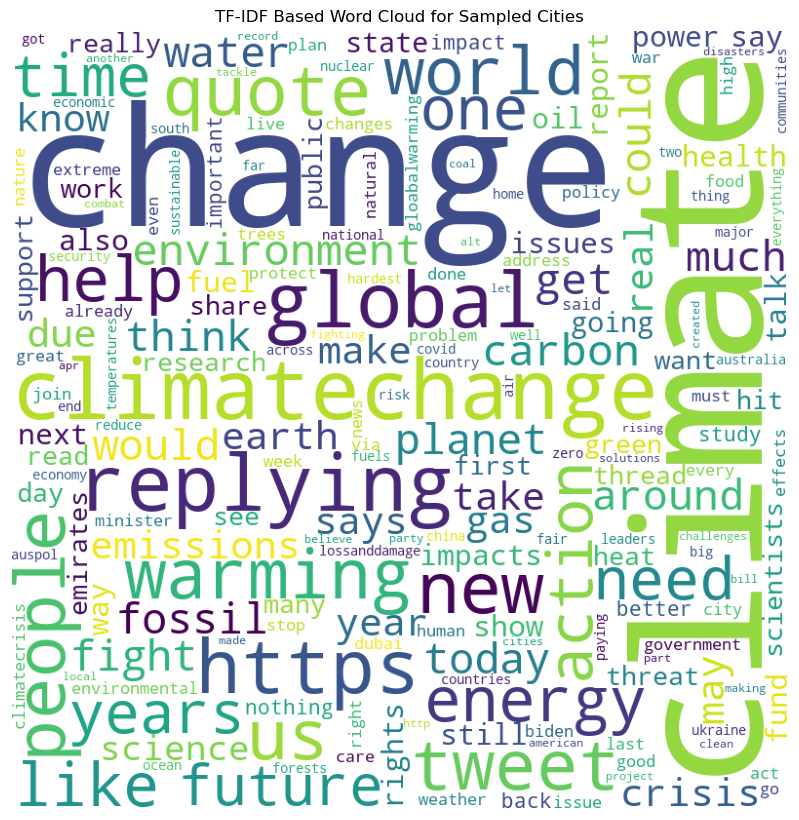

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Function to combine text for each city
def combine_text_for_city(city):
    return ' '.join(tweets_df[tweets_df.City == city]['cleaned_text'].dropna().astype(str))

# Combine text for each city and store in a dictionary
city_texts = {city: combine_text_for_city(city) for city in set(tweets_df.City.dropna())}

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(city_texts.values())

# Summing up the IDF (Inverse Document Frequency) of each term to get their importance
summed_tfidf = np.sum(tfidf_matrix, axis=0)
tfidf_scores = [(word, summed_tfidf[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
tfidf_scores = dict(tfidf_scores)

# Generate a word cloud based on TF-IDF scores
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(tfidf_scores)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.title('TF-IDF Based Word Cloud for Sampled Cities')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Graph with *#*

In [29]:
# Function to extract hashtags from a tweet, with a check for non-string values
def extract_hashtags(text):
    if not isinstance(text, str):
        return []
    return re.findall(r"#(\w+)", text)

# Re-running the mapping of users to hashtags
user_hashtags = defaultdict(set)

for index, row in tweets_df.iterrows():
    user = row['UserName']
    hashtags = extract_hashtags(row['Text'])
    for hashtag in hashtags:
        user_hashtags[user].add(hashtag)

# Create a list of edges
edges = []

# For each hashtag, create an edge between every pair of users who tweeted that hashtag
for hashtag, users in user_hashtags.items():
    edges.extend(combinations(users, 2))

# Preview the edges by showing the first 10 entries
edges[:10]

[('ldnont', 'Budget2022'),
 ('justlookup', 'climatechange'),
 ('ClimateCrisis', 'ClimateBrawl'),
 ('ClimateCrisis', 'ClimateEmergency'),
 ('ClimateBrawl', 'ClimateEmergency'),
 ('climatechange', 'lismorefloods'),
 ('climatechange', 'nswpol'),
 ('climatechange', 'auspol'),
 ('climatechange', 'insiders'),
 ('lismorefloods', 'nswpol')]

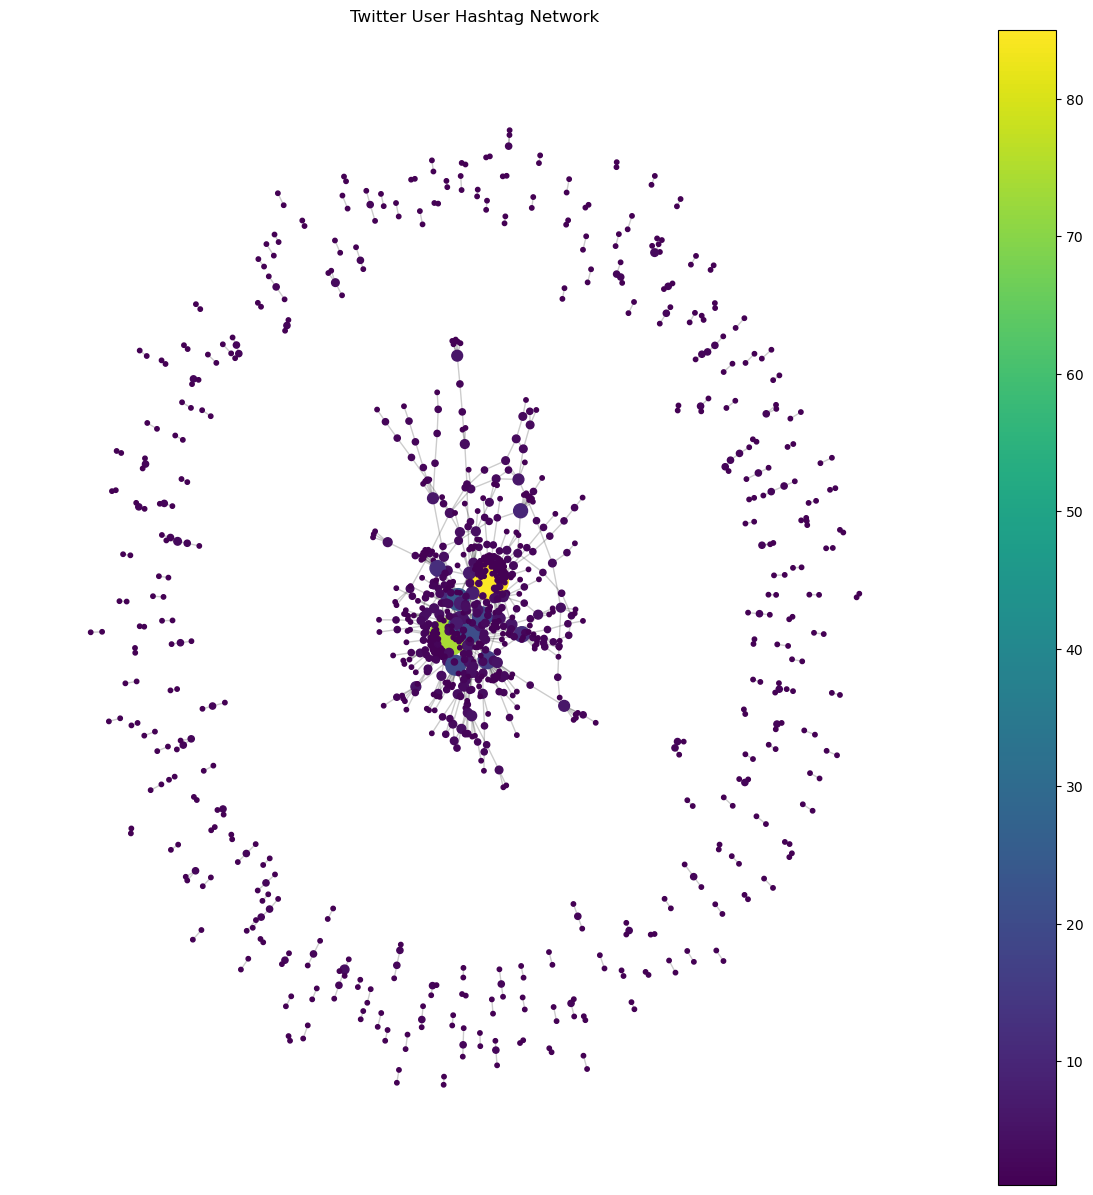

In [30]:
# Sample a subset of edges if the graph is too large
sample_size = 1000  # Adjust this number based on the size and capability of your environment
sampled_edges = random.sample(edges, min(sample_size, len(edges)))

# Create a smaller graph with the sampled edges
G_sampled = nx.Graph()
G_sampled.add_edges_from(sampled_edges)

# Use the spring layout for better node distribution
pos = nx.spring_layout(G_sampled, seed=42)  # Seed for reproducible layout

# Calculate node degrees (number of connections)
degrees = dict(nx.degree(G_sampled))

# Draw the graph with node size proportional to degree and color by degree
plt.figure(figsize=(15, 15))
nodes = nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 10 for v in degrees.values()],
                               node_color=list(degrees.values()), cmap=plt.cm.viridis)
edges = nx.draw_networkx_edges(G_sampled, pos, alpha=0.2)
plt.colorbar(nodes)
plt.axis('off')
plt.title('Twitter User Hashtag Network')
plt.show()

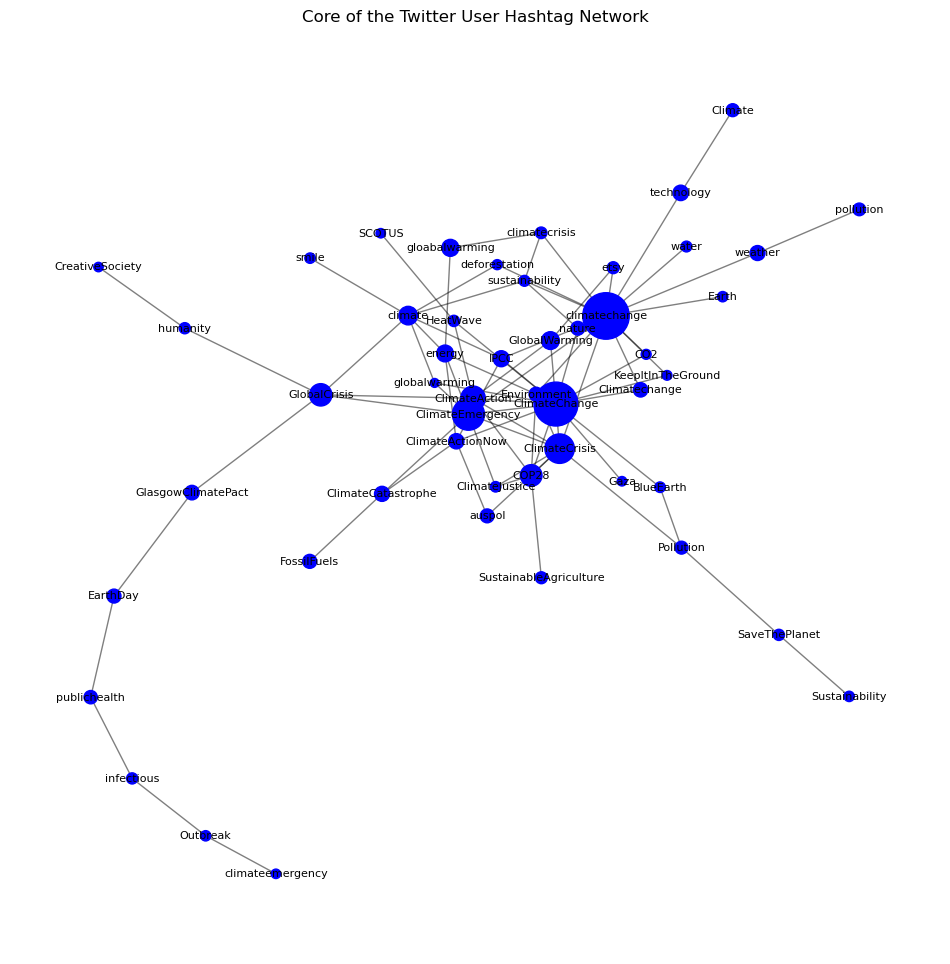

In [31]:
# Recreate the sampled graph
G_sampled = nx.Graph()
G_sampled.add_edges_from(sampled_edges)

# Identify central nodes using betweenness centrality
centrality = nx.betweenness_centrality(G_sampled)
# Sort nodes by centrality and pick the top N
top_central_nodes = sorted(centrality, key=centrality.get, reverse=True)[:50] 

# Create a subgraph around these central nodes
H = G_sampled.subgraph(top_central_nodes)

# Layout for better readability
pos = nx.spring_layout(H, seed=42)

# Visualization
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(H, pos, node_size=[centrality[node] * 10000 for node in H], node_color='blue')
nx.draw_networkx_edges(H, pos, alpha=0.5)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.axis('off')
plt.title('Core of the Twitter User Hashtag Network')
plt.show()

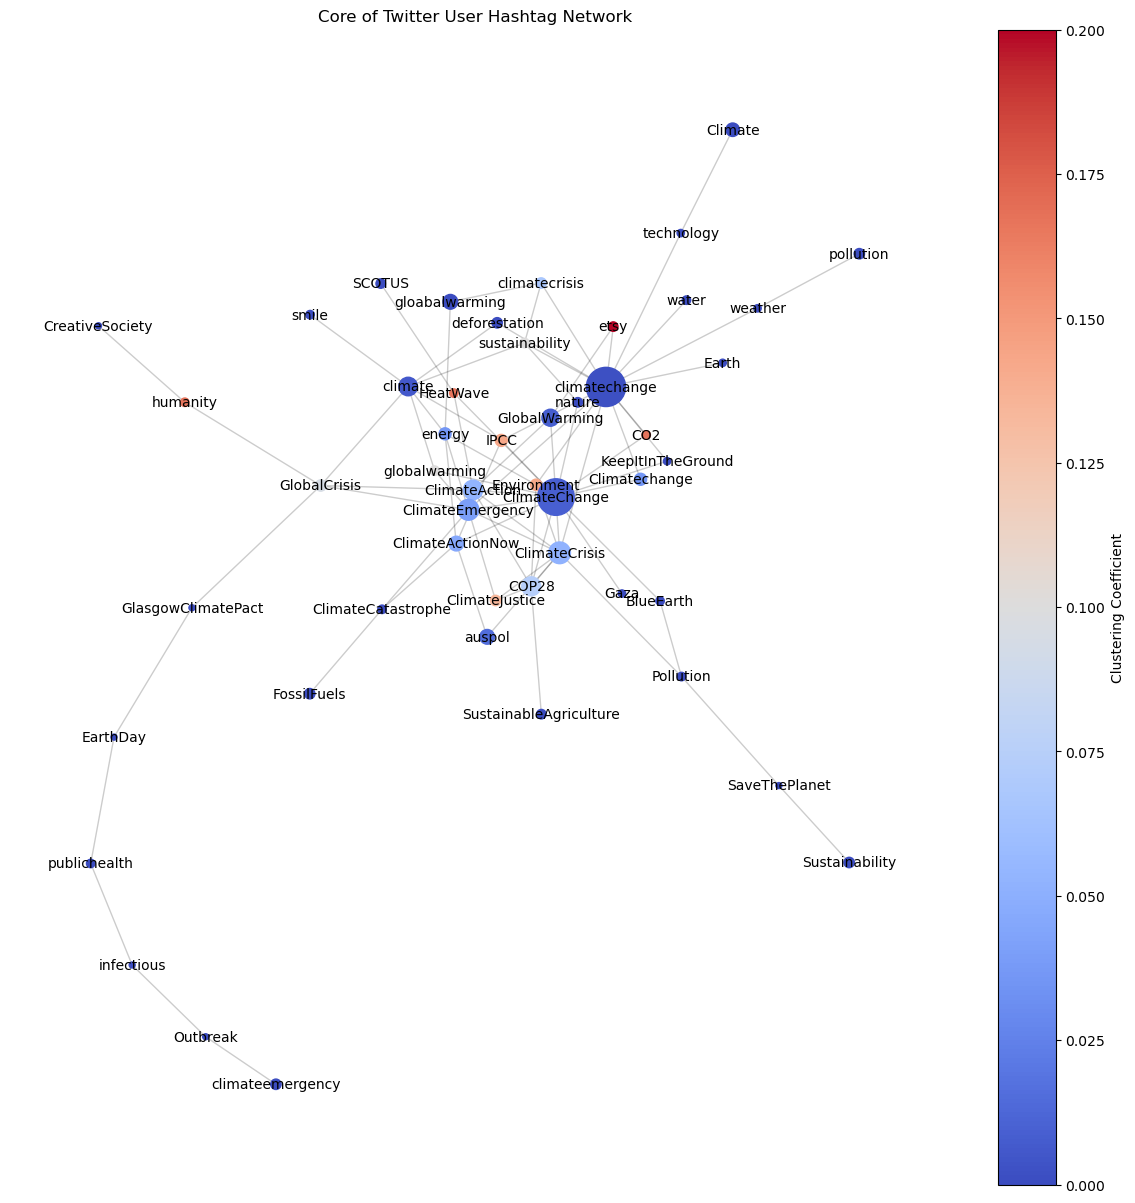

In [32]:
# Node color by clustering coefficient
clustering = nx.clustering(G_sampled)
# Node size by degree centrality
degree_centrality = nx.degree_centrality(G_sampled)

# Recreate the subgraph around the central nodes
H = G_sampled.subgraph(top_central_nodes)

# Layout
pos = nx.spring_layout(H, seed=42)

# Visualization
plt.figure(figsize=(15, 15))
nodes = nx.draw_networkx_nodes(H, pos, 
                               node_size=[degree_centrality[node] * 10000 for node in H],
                               node_color=[clustering[node] for node in H],
                               cmap=plt.cm.coolwarm)
edges = nx.draw_networkx_edges(H, pos, alpha=0.2)
labels = nx.draw_networkx_labels(H, pos, font_size=10)
plt.colorbar(nodes, label='Clustering Coefficient')
plt.axis('off')
plt.title('Core of Twitter User Hashtag Network')
plt.show()

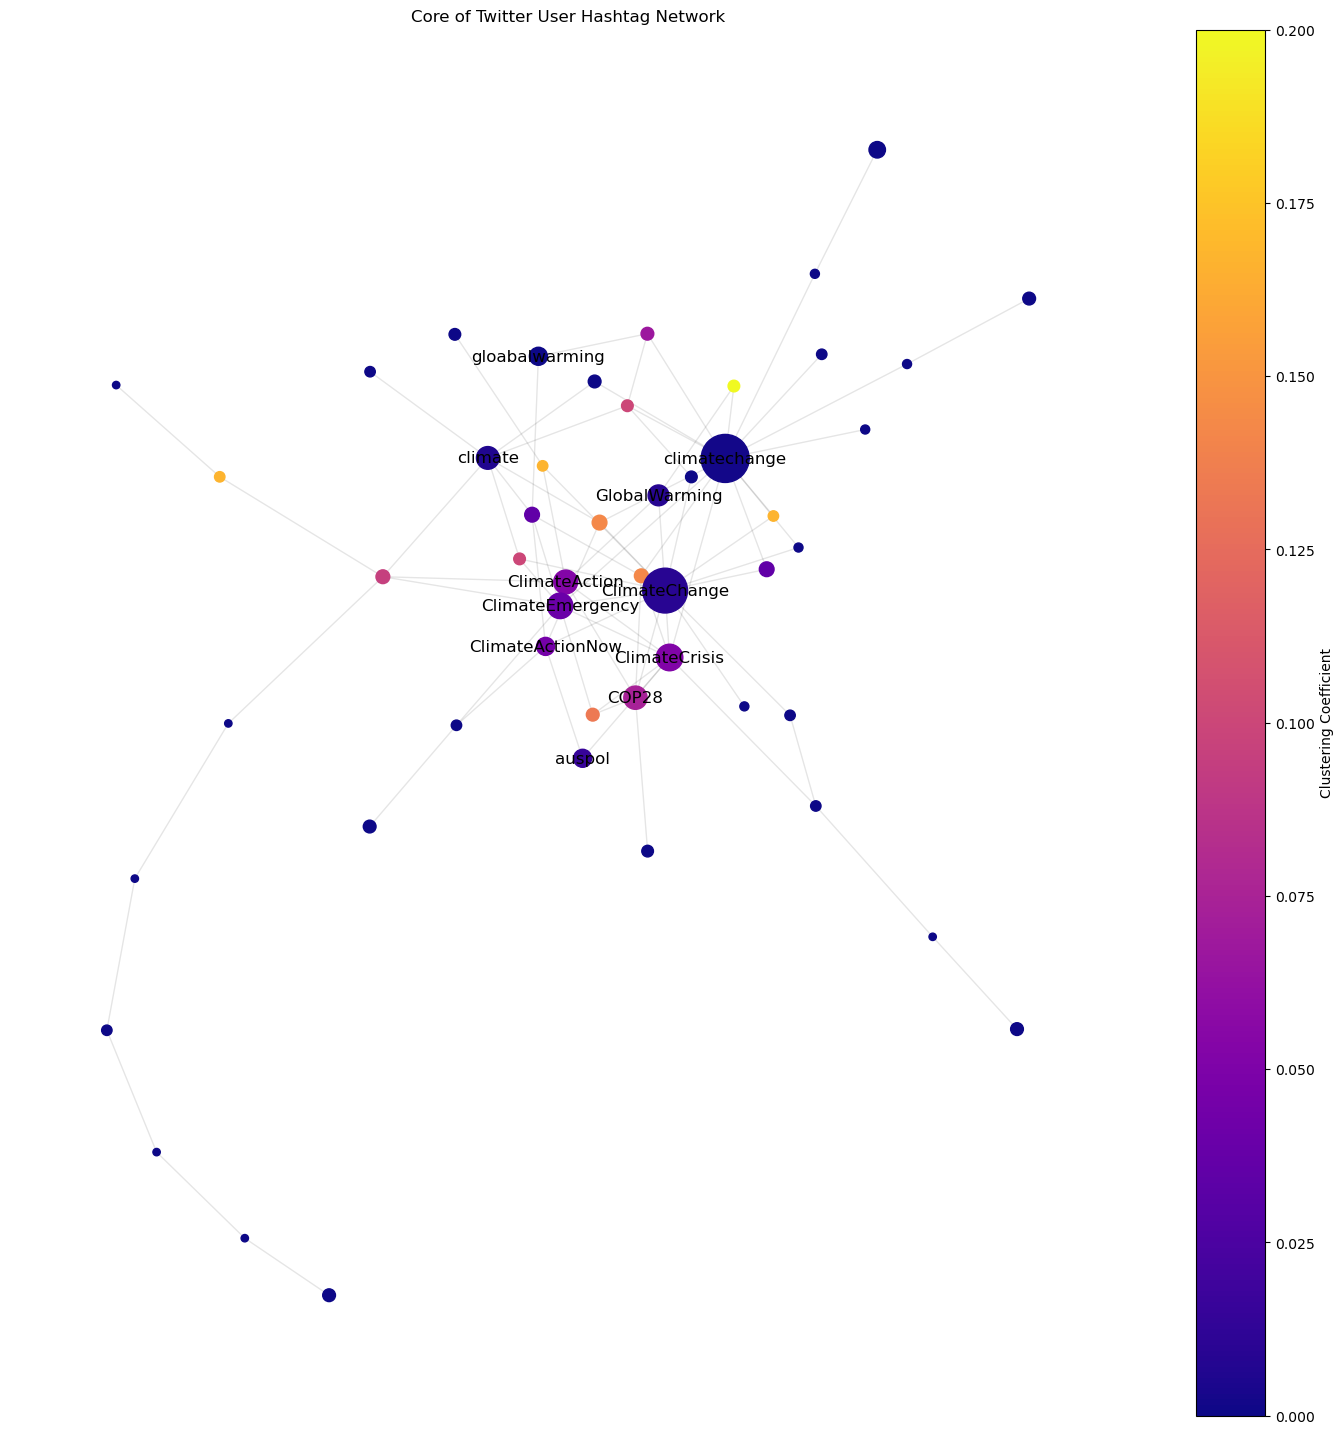

In [33]:
# Set a higher threshold for labeling nodes to reduce clutter
label_threshold = 0.01  # Adjust as needed based on the centrality measures

# Enhanced Visualization
plt.figure(figsize=(18, 18))
# Apply a diverse color palette
colors = [clustering[node] for node in H]
nodes = nx.draw_networkx_nodes(H, pos, 
                               node_size=[degree_centrality[node] * 15000 for node in H],
                               node_color=colors, cmap=plt.cm.plasma)

# Make edges less prominent
nx.draw_networkx_edges(H, pos, alpha=0.1)

# Label only the most central nodes
labels = {node: node if degree_centrality[node] > label_threshold else '' for node in H}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=12)

# Add a color bar for interpretation
plt.colorbar(nodes, label='Clustering Coefficient')
plt.axis('off')
plt.title('Core of Twitter User Hashtag Network')
plt.show()

* Node Size: Reflects the degree centrality of each user, with larger nodes indicating more connections.
* Node Color: Varied across a plasma color map based on clustering coefficients, providing a vivid representation of local clustering.
* Labels: Applied selectively to only the most central nodes, based on a higher centrality threshold, to reduce clutter and focus on key influencers.
* Edges: Made less prominent to direct attention primarily to the nodes.